In [1]:
import numpy as np


import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn.functional as F

import pandas as pd

from matplotlib import pyplot as plt

%matplotlib inline

from livelossplot import PlotLosses

Using TensorFlow backend.


In [2]:
data = {}
def data_load(classes_num, directories): #pobiera dane, argumenty: ilość rozpoznawanych klas, lista miejsc przechowywania danych
    for i in range(classes_num):
        data[i] = np.load(directories[i])
    return data[0].shape
        

In [12]:
data_load(2, ["/home/user/data/airplane.npy", "/home/user/data/onion.npy"])

(151623, 784)

In [13]:
def format_data(amount): #Formatuje dane do użycia w sieci, argument: ile danych ma pobrać do treningów i testów z każdej kategorii
    data_train = {}
    X_train = torch.tensor([])
    Y_train = torch.LongTensor([])
    for i in range(len(data)):
        data_train[i] =torch.from_numpy(data[i][:amount].reshape(-1, 1, 28, 28).astype('float32')/255)
        X_train = torch.cat((X_train, data_train[i]), 0)
        Y_train = torch.cat((Y_train, torch.LongTensor(amount*[i])),0)
        
    data_test = {}
    X_test = torch.tensor([])
    Y_test = torch.LongTensor([])
    for i in range(len(data)):
        data_test[i] =torch.from_numpy(data[i][amount:2*amount].reshape(-1, 1, 28, 28).astype('float32')/255)
        X_test = torch.cat((X_test, data_test[i]), 0)
        Y_test = torch.cat((Y_test, torch.LongTensor(amount*[i])),0)
        
    return X_train, Y_train, X_test, Y_test

In [19]:
format_data(50)

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [64]:
classes_num = 2
class Net(nn.Module):
    def __init__(self, classes_num):
        self.classes_num = classes_num
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, self.classes_num)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [65]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_accuracy = train_correct / len(train_loader.dataset)
    

        
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return avg_loss, avg_accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    

    test_loss /= len(test_loader.dataset)
    avg_loss_val = test_loss
    avg_accuracy_val = test_correct / len(test_loader.dataset)

    
        

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))
    
    return avg_loss_val, avg_accuracy_val



In [72]:
def apply( epoch, classes_num ): #stosuje wcześniej zdefiniowane funkcje, argument: epoch-ilość przejśc przez dane treningowe, class_num-ilość klas
    model = Net(classes_num)
    device = torch.device("cpu")
    X_train, Y_train, X_test, Y_test = format_data(100)        
    train_loader  = DataLoader(TensorDataset(X_train,Y_train),
                         batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, Y_test),
                         batch_size=32, shuffle=False)  
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    liveloss = PlotLosses()

    for epoch in range(epoch):

        avg_loss, avg_accuracy = train(model, device, train_loader, optimizer, epoch)  
        avg_loss_val, avg_accuracy_val = test(model, device, test_loader)
    
        liveloss.update({
            'val_log loss': avg_loss_val,
            'val_accuracy': avg_accuracy_val,
            'log loss': avg_loss,
            'accuracy': avg_accuracy,
        })
    
        liveloss.draw()




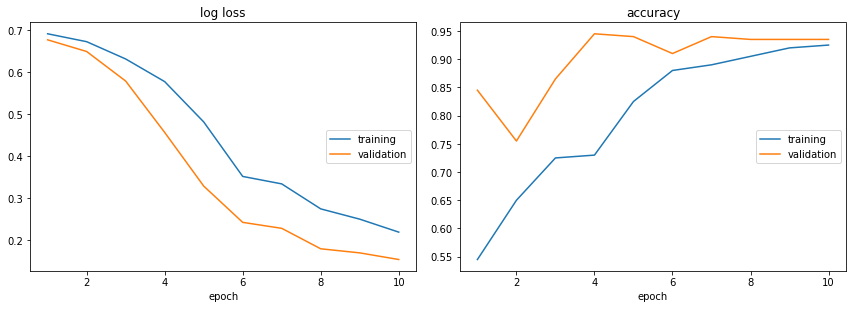

In [74]:
#define(2)
apply(10, 2)